In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from scipy.sparse import linalg as spla
import spectral

## Non-Fully Periodic BVP

In [3]:
N = 64
x_basis = spectral.Fourier(N)
y_basis = spectral.Chebyshev(N)
domain = spectral.Domain([x_basis, y_basis])
u = spectral.Field(domain)
v = spectral.Field(domain)
x, y = domain.grids()
xm, ym = np.meshgrid(x.ravel(), y.ravel())

In [4]:
problem = spectral.BoundaryValueProblem(domain, [u, v], num_BCs=4)

In [5]:
diag = np.arange(N-1) + 1
D = sparse.diags(diag, offsets=1)

diag0 = np.ones(N)/2
diag0[0] = 1
diag2 = -np.ones(N-2)/2
C = sparse.diags((diag0, diag2), offsets=(0, 2))

Z = sparse.csr_matrix((N, N))

In [6]:
for p in problem.pencils:
    n = p.wavenumbers[0]
    
    L = sparse.bmat([[ -D,    Z,   Z, -n*C],
                     [  Z,   -D, n*C,    Z],
                     [n*C,    Z,   Z,    D],
                     [  Z, -n*C,   D,    Z]])
    
    BC_rows = np.zeros((4, 4*N))
    i = np.arange(N)
    if n != 0:
        BC_rows[0, 3*N:4*N] = (-1)**i
        BC_rows[1, 2*N:3*N] = (-1)**i
        BC_rows[2, 3*N:4*N] = (+1)**i
        BC_rows[3, 2*N:3*N] = (+1)**i
    else: #n==0
        BC_rows[0, 0*N:1*N] = (-1)**i
        BC_rows[1, 1*N:2*N] = (-1)**i
        BC_rows[2, 2*N:3*N] = (-1)**i
        BC_rows[3, 3*N:4*N] = (-1)**i

        
    cols = np.zeros((4*N, 4))
    cols[  N-1, 0] = 1
    cols[2*N-1, 1] = 1
    cols[3*N-1, 2] = 1
    cols[4*N-1, 3] = 1
    
    corner = np.zeros((4,4))
    
    p.L = sparse.bmat([[L, cols],
                       [BC_rows, corner]])

<IPython.core.display.Javascript object>


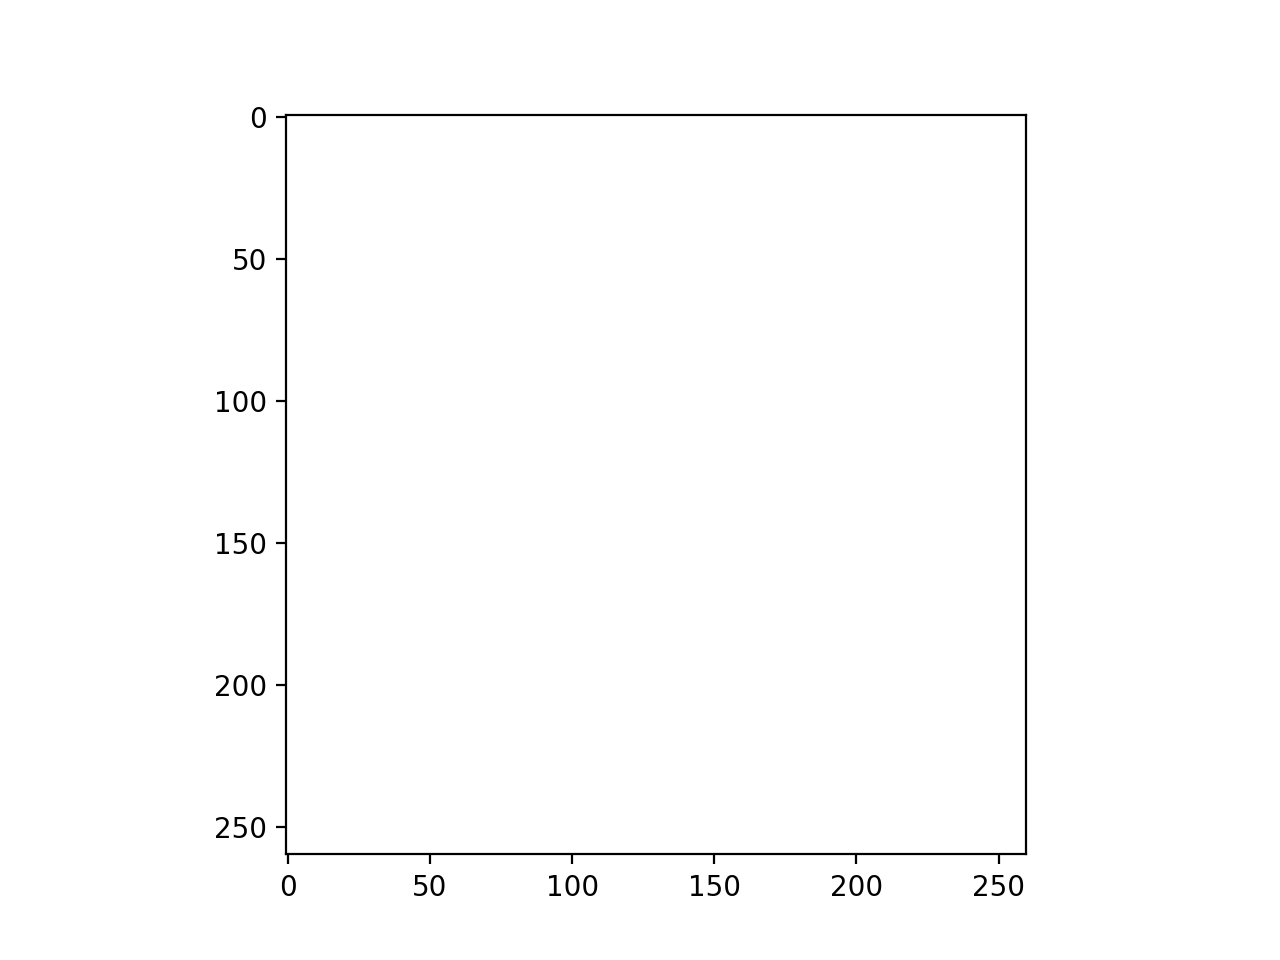

/var/folders/yl/n21qhxyn5093pv7cynvb2_7w0000gn/T/ipykernel_43562/1247603200.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(problem.pencils[0].L.A)))


In [7]:
plt.figure()
plt.imshow(np.log(np.abs(problem.pencils[0].L.A)))

In [8]:
om = spectral.Field(domain)
om.require_grid_space()
r = np.sqrt((x-np.pi)**2 + y**2)
om.data = 20*(1-5*r**2)*np.exp(-5*r**2)
om.require_coeff_space()
om.data[:2, :2] = 0
zeros = spectral.Field(domain)
F = spectral.StateVector([om, zeros], problem, num_BCs=4)

In [9]:
def BC_func(wavenumbers):
    return [0, 0, 0, 0]

In [10]:
problem.solve(F, BC_func)

<IPython.core.display.Javascript object>


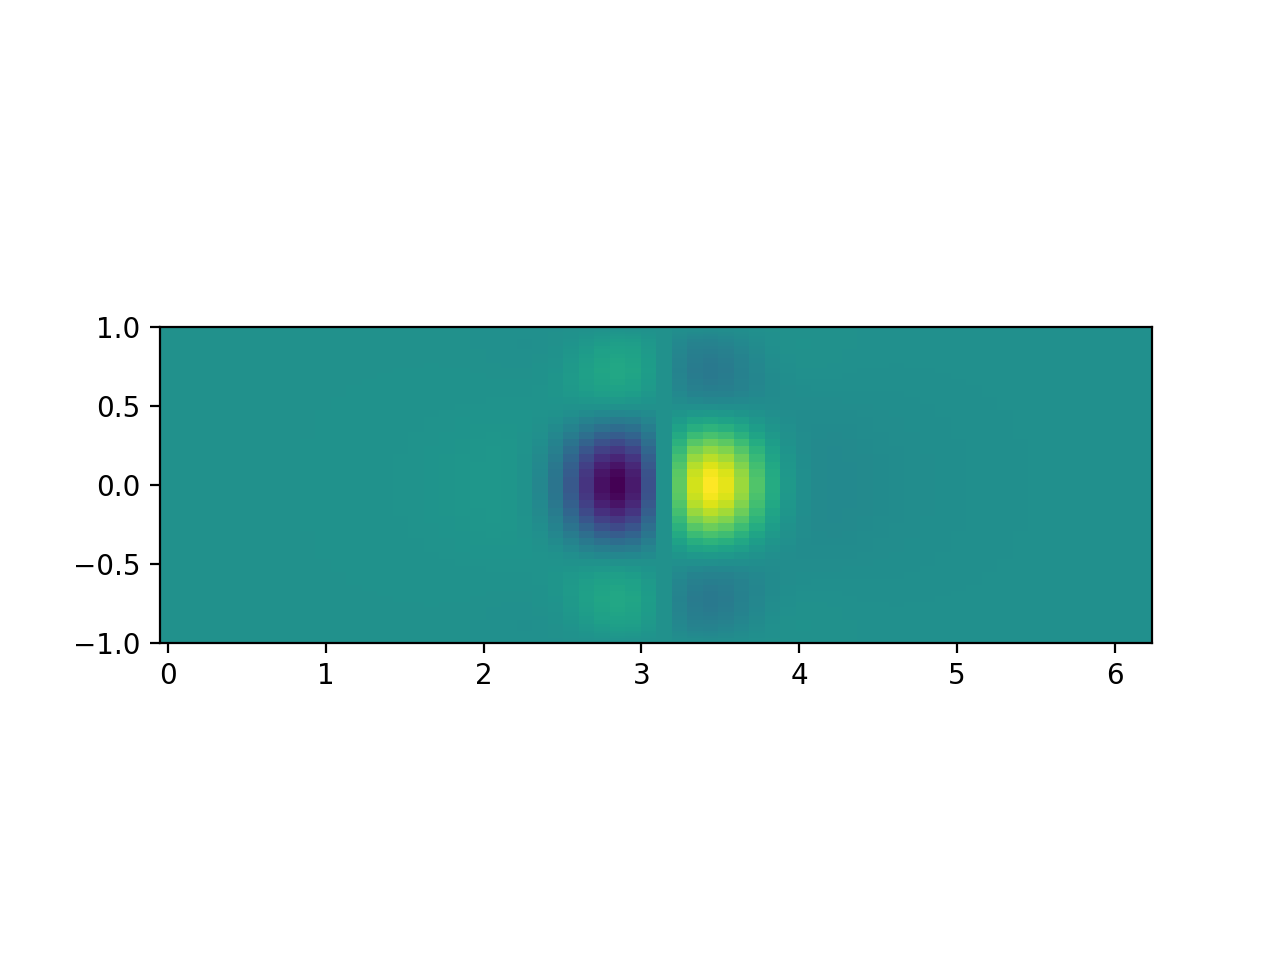

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
v.require_grid_space()
ax.pcolormesh(xm, ym, v.data.T)

In [12]:
N = 128
x_basis = spectral.Fourier(N)
y_basis = spectral.Chebyshev(N)
domain = spectral.Domain([x_basis, y_basis])
c = spectral.Field(domain)
cy = spectral.Field(domain)
c_RHS = spectral.Field(domain)
cy_RHS = spectral.Field(domain)
x, y = domain.grids()
xm, ym = np.meshgrid(x.ravel(), y.ravel())

dt = 5e-2
s = 1e-3
R = 1

In [13]:
problem = spectral.InitialValueProblem(domain, [c, cy], [c_RHS, cy_RHS], num_BCs=4)

In [14]:
diag = np.arange(N-1) + 1
D = sparse.diags(diag, offsets=1)

diag0 = np.ones(N)/2
diag0[0] = 1
diag2 = -np.ones(N-2)/2
C = sparse.diags((diag0, diag2), offsets=(0, 2))

Z = sparse.csr_matrix((N, N))

In [15]:
for p in problem.pencils:
    n = p.wavenumbers[0]
    
    p.M = sparse.csr_matrix((4*N+4, 4*N+4))
    p.M[2*N:3*N, :N] = C
    p.M[3*N:4*N, N:2*N] = C
    p.M.eliminate_zeros()
    
    L = sparse.bmat([[       D,        Z,   -C,    Z],
                     [       Z,        D,    Z,   -C],
                     [s*n**2*C,        Z, -s*D,    Z],
                     [       Z, s*n**2*C,    Z, -s*D]])
    
    i = np.arange(N)
    BC_rows = np.zeros((4, 4*N))
    BC_rows[0, :N] = (-1)**i
    BC_rows[1, :N] = (+1)**i
    BC_rows[2, N:2*N] = (-1)**i
    BC_rows[3, N:2*N] = (+1)**i
    
    cols = np.zeros((4*N,4))
    cols[  N-1, 0] = 1
    cols[2*N-1, 1] = 1
    cols[3*N-1, 2] = 1
    cols[4*N-1, 3] = 1
    
    corner = np.zeros((4,4))
    
    p.L = sparse.bmat([[L, cols],
                       [BC_rows, corner]])
    
    p.L.eliminate_zeros()
    

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [16]:
ts = spectral.SBDF2(problem)

<IPython.core.display.Javascript object>


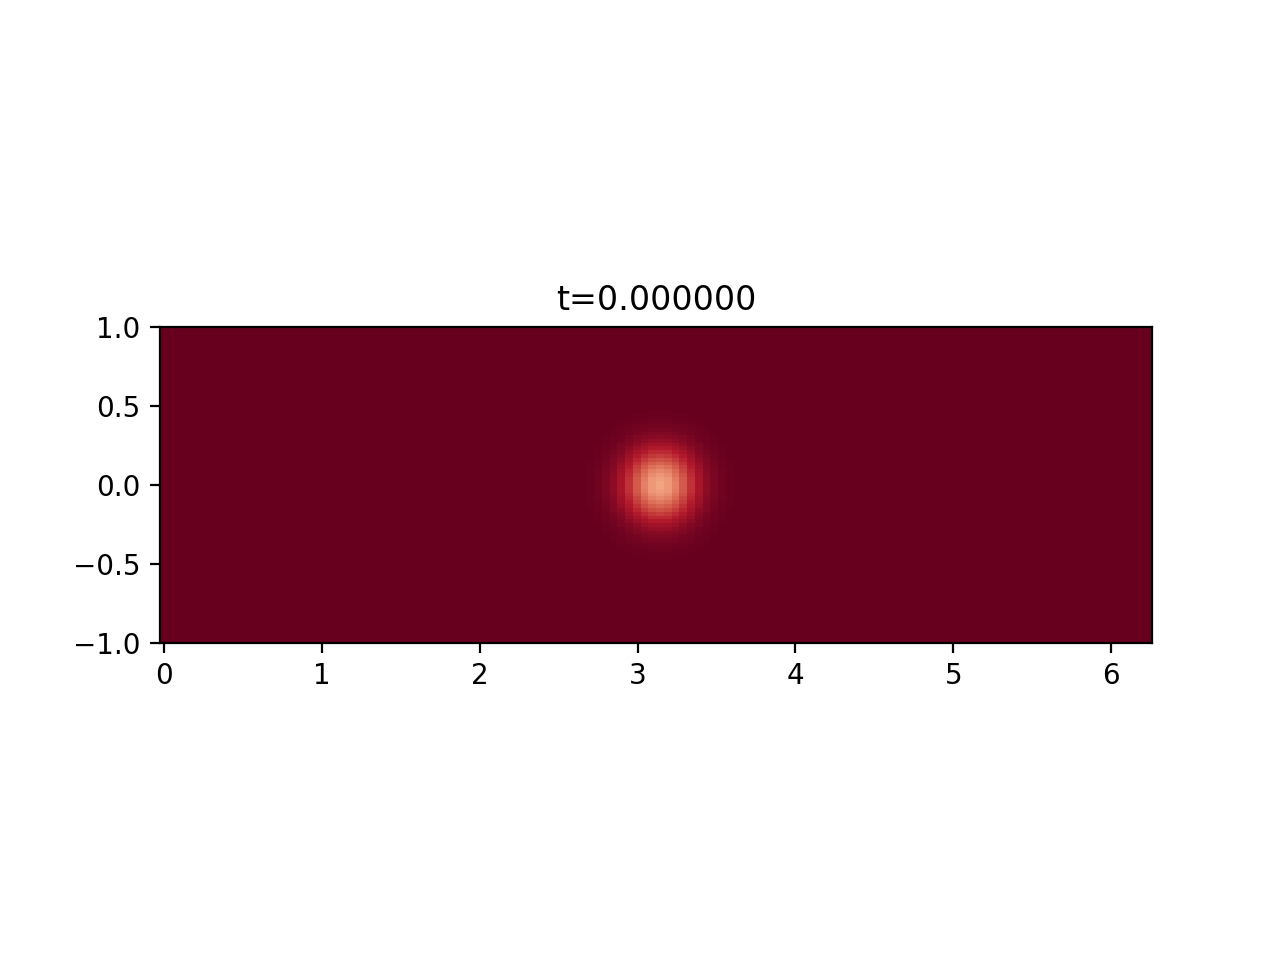

In [17]:
c.require_grid_space()
r = np.sqrt((x-np.pi)**2 + y**2)
c.data = 0.3*np.exp(-20*r**2)

fig = plt.figure()
ax = fig.subplots(1)
ax.pcolormesh(xm, ym, c.data.T, cmap='RdBu', vmax=1)
ax.set_aspect(1)
fig.canvas.draw()
title = plt.title('t=%f' %ts.time)